# Image Reconstruction

In [1]:
import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')
#pv.OFF_SCREEN=True

In [2]:
import time
import os

import matplotlib.pyplot as p
import numpy as np
import xarray as xr
from IPython.display import Image

import cedalion
import cedalion.dataclasses as cdc
import cedalion.datasets
import cedalion.sigproc.quality as quality
import cedalion.geometry.registration
import cedalion.geometry.segmentation
import cedalion.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.io
import cedalion.plots
import cedalion.vis.plot_sensitivity_matrix
from cedalion.imagereco.solver import pseudo_inverse_stacked

xr.set_options(display_expand_data=False);

## Decide for an example with a sparse probe or a high density probe for DOT.
The notebook will load example data accordingly.

In [3]:
# choose between two datasets
DATASET = "fingertappingDOT" # high-density montage
#DATASET = "fingertapping"   # sparse montage

# choose a head model
HEAD_MODEL = "colin27"
#HEAD_MODEL = "icbm152"

# choose between the monte
FORWARD_MODEL = "MCX" # photon monte carlo
#FORWARD_MODEL = "NIRFASTER" # finite element method

# set this flag to False to actual compute the forward model results
PRECOMPUTED_FLUENCE = True

## Load a DOT finger-tapping dataset 

For this demo we load an example finger-tapping recording through `cedalion.datasets.get_fingertapping`. The file contains a single NIRS element with one block of raw amplitude data. 

In [4]:
if DATASET == "fingertappingDOT":
    rec = cedalion.datasets.get_fingertappingDOT()
elif DATASET == "fingertapping":
    rec = cedalion.datasets.get_fingertapping()
else:
    raise ValueError("unknown dataset")

The location of the probes is obtained from the snirf metadata (i.e. /nirs0/probe/)

Note that units ('m') are adopted and the coordinate system is named 'digitized'.

In [5]:
geo3d_meas = rec.geo3d
display(geo3d_meas)

Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


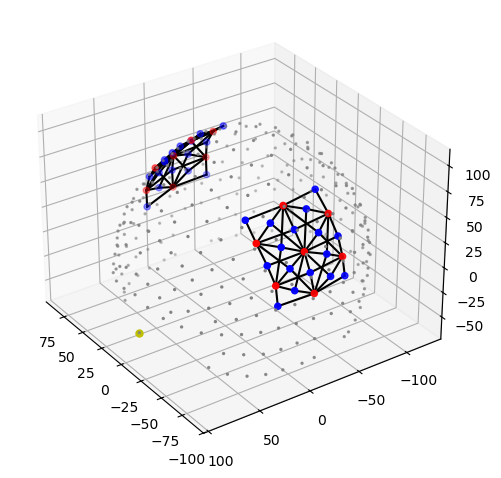

In [6]:
cedalion.plots.plot_montage3D(rec["amp"], geo3d_meas)

The measurement list is a `pandas.DataFrame` that describes which source detector pairs form channels.

In [7]:
meas_list = rec._measurement_lists["amp"]
display(meas_list.head(5))

,sourceIndex,detectorIndex,wavelengthIndex,wavelengthActual,wavelengthEmissionActual,dataType,dataUnit,dataTypeLabel,dataTypeIndex,sourcePower,detectorGain,moduleIndex,sourceModuleIndex,detectorModuleIndex,channel,source,detector,wavelength,chromo
0,1,1,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D1,S1,D1,760.0,None
1,1,2,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D2,S1,D2,760.0,None
2,1,4,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D4,S1,D4,760.0,None
3,1,5,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D5,S1,D5,760.0,None
4,1,6,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D6,S1,D6,760.0,None


Event/stimulus information is also stored in a `pandas.DataFrame`. Here events are given more descriptive names:

In [8]:

if DATASET == "fingertappingDOT":
   rec.stim.cd.rename_events( {
        "1": "Control", 
        "2": "FTapping/Left", 
        "3": "FTapping/Right",
        "4": "BallSqueezing/Left",
        "5": "BallSqueezing/Right"
    } )
elif DATASET == "fingertapping":
    rec.stim.cd.rename_events( {
        "1.0": "Control", 
        "2.0": "FTapping/Left", 
        "3.0": "FTapping/Right"
    } )

display(rec.stim.groupby("trial_type")[["onset"]].count())

,onset
trial_type,
BallSqueezing/Left,17
BallSqueezing/Right,16
Control,65
FTapping/Left,16
FTapping/Right,16


### Perform pruning, conversion to OD and bandpass filtering
(for this demo select 20 seconds after a trial starts at t=117s and transform raw amplitudes to optical density)

Perform SNR quality check and pruning and then transform CW raw amplitudes to optical density

In [9]:
## Prune with SNR threshold
snr_thresh = 10 # dB
snr, rec.masks["snr_mask"] = quality.snr(rec["amp"], snr_thresh)
# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
rec["amp_pruned"], drop_list = quality.prune_ch(rec["amp"], [rec.masks["snr_mask"]], "all")

print(drop_list)

# Convert to OD
rec["od"] = cedalion.nirs.int2od(rec["amp_pruned"])

# bandpass filter the data
rec["od_freqfiltered"] = rec["od"].cd.freq_filter(fmin=0.01, fmax=0.5, butter_order=4)

mask collapsed to channel dimension
[]


## Calculate block averages in optical density

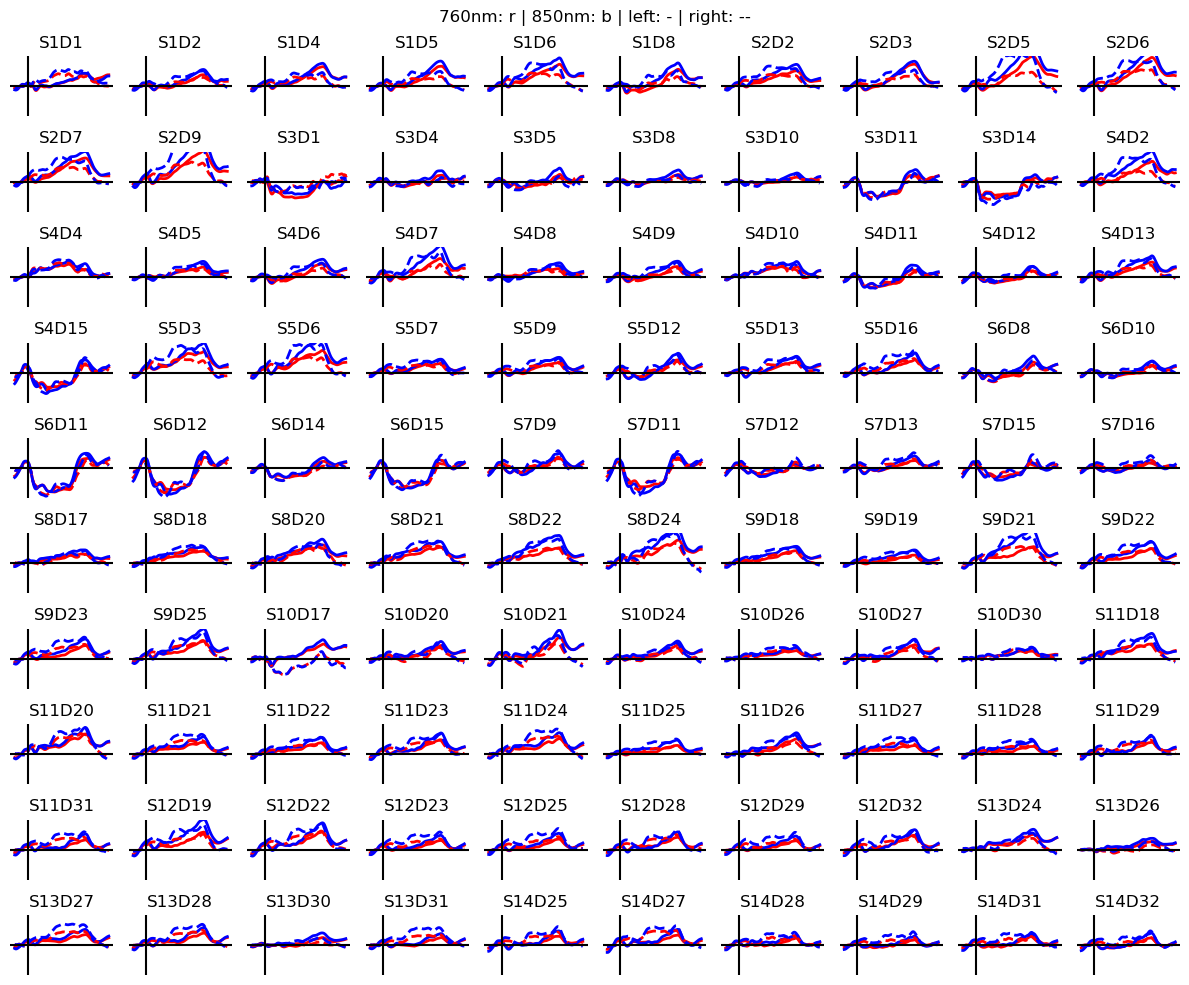

In [10]:
# segment data into epochs
epochs = rec["od_freqfiltered"].cd.to_epochs(
        rec.stim, # stimulus dataframe
        ["FTapping/Left", "FTapping/Right"],  # select events, discard the others
        before=5, # seconds before stimulus
        after=30  # seconds after stimulus
)

# calculate baseline
baseline = epochs.sel(reltime=(epochs.reltime < 0)).mean("reltime")
# subtract baseline
epochs_blcorrected = epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage = epochs_blcorrected.groupby("trial_type").mean("epoch")

# Plot block averages. Please ignore errors if the plot is too small in the HD case

noPlts2 = int(np.ceil(np.sqrt(len(blockaverage.channel))))
f,ax = p.subplots(noPlts2,noPlts2, figsize=(12,10))
ax = ax.flatten()
for i_ch, ch in enumerate(blockaverage.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):    
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(wavelength=760, trial_type=trial_type, channel=ch), "r", lw=2, ls=ls)
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(wavelength=850, trial_type=trial_type, channel=ch), "b", lw=2, ls=ls)

    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-.02, .02)
    ax[i_ch].set_axis_off()
    ax[i_ch].axhline(0, c="k")
    ax[i_ch].axvline(0, c="k")

p.suptitle("760nm: r | 850nm: b | left: - | right: --")
p.tight_layout()


## Load segmented MRI scan

For this example use a segmentation of the Colin27 average brain.

In [11]:
if HEAD_MODEL == "colin27":
    SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
elif HEAD_MODEL == "icbm152":
    SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_icbm152_segmentation()
else:
    raise ValueError("unknown head model")

The segmentation masks are in individual niftii files. The dict `mask_files` maps mask filenames relative to `SEG_DATADIR` to short labels. These labels describe the tissue type of the mask. 

In principle the user is free to choose these labels. However, they are later used to lookup the tissue's optical properties. So they must be map to one of the tabulated tissue types (c.f. `cedalion.imagereco.tissue_properties.TISSUE_LABELS`).

The variable `landmarks_file` holds the path to a file containing landmark positions in scanner space (RAS). This file can be created with Slicer3D.

In [12]:
display(SEG_DATADIR)
display(mask_files)
display(landmarks_file)

'/Users/shakiba/Library/Caches/cedalion/colin27_segmentation.zip.unzip/colin27_segmentation'

{'csf': 'mask_csf.nii',
 'gm': 'mask_gray.nii',
 'scalp': 'mask_skin.nii',
 'skull': 'mask_bone.nii',
 'wm': 'mask_white.nii'}

'landmarks.mrk.json'

## Coordinate systems

Up to now we have geometrical data from three different coordinate reference systems (CRS):

- The optode positions are in one space `CRS='digitized'` and the coordinates are in meter. In our example the origin is at the head center and y-axis pointing in the superior direction. Other digitization tools can use other units or coordinate systems.
- The segmentation masks are in voxel space (`CRS='ijk'`) in which the voxel edges are aligned with the coordinate axes. Each voxel has unit edge length, i.e. coordinates are dimensionless. 
  Axis-aligned grids are computationally efficient, which is why the photon simulation code (MCX) uses this coordinate system.
- The voxel space (`CRS='ijk'`) is related to scanner space (`CRS='ras'` or `CRS='aligned'`) in which coordinates have physical units and coordinate axes point to the (r)ight, (a)nterior and s(uperior) directions. The relation between both spaces is given through an affine transformation (e.g. `t_ijk2ras`). When loading the segmentation masks in Slicer3D this transformation is automatically applied. Hence, the picked landmark coordinates are exported in RAS space.

  The niftii file provides a string label for the scanner space. In this example the RAS space is called 'aligned' because the masks are aligned to another MRI scan.


To avoid confusion between these different coordinate systems, `cedalion` tries to be explicit about which CRS a given point cloud or surface is in.

## The TwoSurfaceHeadModel

The photon propagation considers the complete MRI scan, in which each voxel is attributed to one tissue type with its respective optical properties. However, the image reconstruction does not intend to reconstruct absorption changes in each voxel. The inverse problem is simplified, by considering only two surfaces (scalp and brain) and reconstruct only absorption changes in voxels close to these surfaces.

The class `cedalion.imagereco.forward_model.TwoSurfaceHeadModel` groups together the segmentation mask, landmark positions and affine transformations as well as the scalp and brain surfaces. The brain surface is calculated by grouping together white and gray matter masks. The scalp surface encloses the whole head.

In [13]:
head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    landmarks_ras_file=landmarks_file,
    brain_face_count=None,
    scalp_face_count=None
)

In [14]:
head.segmentation_masks

<xarray.DataArray (segmentation_type: 5, i: 181, j: 217, k: 181)> Size: 36MB
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * segmentation_type  (segmentation_type) <U5 100B 'csf' 'gm' ... 'skull' 'wm'
Dimensions without coordinates: i, j, k

In [15]:
head.landmarks

Magnitude,[[89.95007602497844 205.78946685790896 35.85887908935479] [91.75606727600315 25.050003051760854 17.142013549806435] [18.05000305175645 109.8805942535382 17.343021392821214] [165.94999694824514 112.96190643310963 17.922157287600037]]
Units,dimensionless


In [16]:
head.brain

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(15002, 3), faces.shape=(29988, 3))>, crs='ijk', units=<Unit('dimensionless')>)

In [17]:
head.scalp

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(152359, 3), faces.shape=(303548, 3))>, crs='ijk', units=<Unit('dimensionless')>)

`TwoSurfaceHeadModel.from_segmentation` converts everything into voxel space (`CRS='ijk'`)

In [18]:
head.crs

'ijk'

The transformation matrix to translate from voxel to scanner space:

In [19]:
head.t_ijk2ras

Magnitude,[[1.0 0.0 0.0 -90.0] [0.0 1.0 0.0 -126.0] [0.0 0.0 1.0 -72.0] [0.0 0.0 0.0 1.0]]
Units,millimeter


Changing between coordinate systems:

In [20]:
head_ras = head.apply_transform(head.t_ijk2ras)
display(head_ras.crs)
display(head_ras.brain)

'aligned'

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(15002, 3), faces.shape=(29988, 3))>, crs='aligned', units=<Unit('millimeter')>)

## Optode Registration
The optode coordinates from the recording must be aligned with the scalp surface. Currently, `cedaĺion` offers a simple registration method, which finds an affine transformation (scaling, rotating, translating) that matches the landmark positions of the head model and their digitized counter parts. Afterwards, optodes are snapped to the nearest vertex on the scalp.

In [21]:
geo3d_snapped_ijk = head.align_and_snap_to_scalp(geo3d_meas)
display(geo3d_snapped_ijk)

Magnitude,[[9.90067996231771 129.00337747726593 88.00475372480513] [23.582338748341726 135.01064219022152 127.01891885183414] [7.932222335114538 104.96269831836995 69.95882079097112] ... [169.33044450804715 157.02447876179895 37.25591035636485] [173.07561584082652 139.99870147158805 34.9965150873531] [172.03364292496812 125.98707966194677 34.9768180480424]]
Units,dimensionless


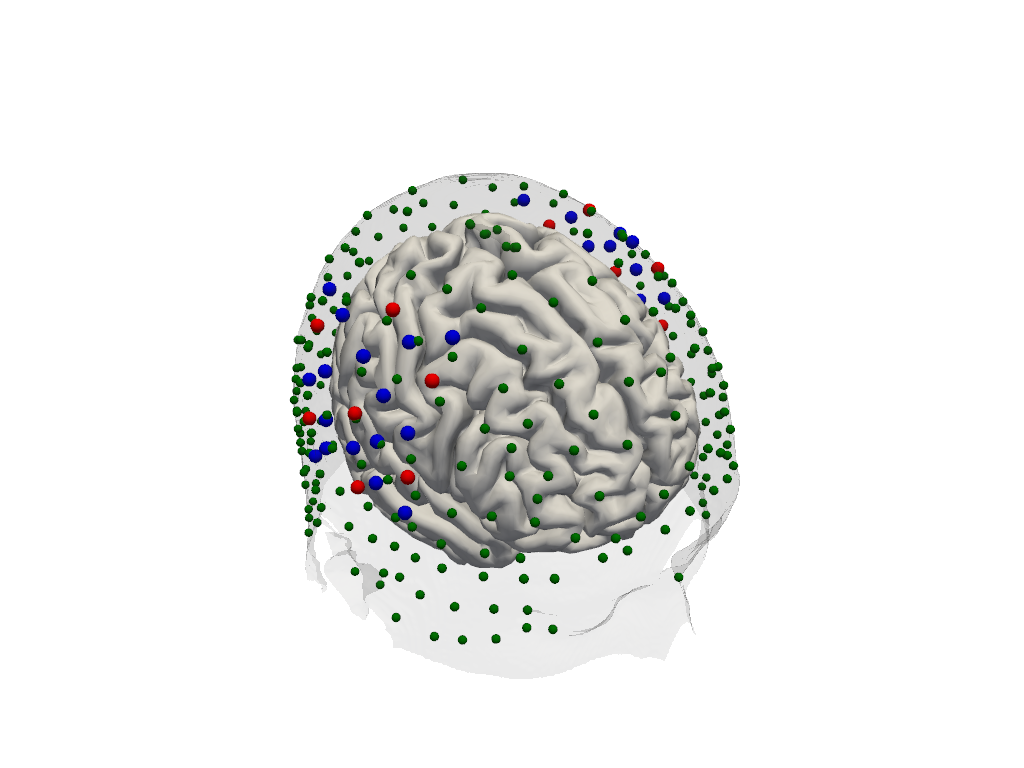

In [22]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()

## Simulate light propagation in tissue

`cedalion.imagereco.forward_model.ForwardModel` is a wrapper around pmcx. Using the data in the head model it prepares the inputs for either pmcx or NIRFASTer and offers functionality to calculate the sensitivty matrix.

In [ ]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped_ijk, meas_list)

### Run the simulation

The `compute_fluence_mcx` and `compute_fluence_nirfaster` methods simulate a light source at each optode position and calculate the fluence in each voxel. By setting `RUN_PACKAGE`, you can choose between the pmcx or NIRFASTer package to perform this simulation.
PLEASE NOTE: if you USE_CACHED data (download the example data) be aware that the file is quite big (~2GB).

In [ ]:
if PRECOMPUTED_FLUENCE:
    if FORWARD_MODEL == "MCX":
        fluence_all, fluence_at_optodes = cedalion.datasets.get_precomputed_fluence(DATASET, HEAD_MODEL)
    elif FORWARD_MODEL == "NIRFASTER":
        raise NotImplementedError("Currently there are  no precomputed NIRFASTER results available")
else:
    if FORWARD_MODEL == "MCX":
        fluence_all, fluence_at_optodes = fwm.compute_fluence_mcx()
    elif FORWARD_MODEL == "NIRFASTER":
        fluence_all, fluence_at_optodes = fwm.compute_fluence_nirfaster()

The photon simulation yields the fluence in each voxel for each wavelength.

In [ ]:
fluence_all

Also, for a each combination of two optodes, the fluence in the voxels at the optode positions is calculated.

In [ ]:
fluence_at_optodes

## Plot fluence

To illustrate the tissue probed by light travelling from a source to the detector two fluence profiles need to be multiplied. 

In [ ]:
# for plotting use a geo3d without the landmarks
geo3d_plot = geo3d_snapped_ijk[geo3d_snapped_ijk.type != cdc.PointType.LANDMARK]

In [ ]:
time.sleep(1)

plt = pv.Plotter()

if DATASET == "fingertappingDOT":
    src, det, wl = "S4", "D2", 760
elif DATASET == "fingertapping":
    src, det, wl = "S2", "D3", 760
else:
    raise ValueError("unknown dataset")

f = fluence_all.loc[src, wl].values * fluence_all.loc[det, wl].values
f[f <= 0] = f[f > 0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt.add_volume(
    vf,
    log_scale=False,
    cmap="plasma_r",
    clim=(-10, 0),
)
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_labeled_points(plt, geo3d_plot, show_labels=False)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [-300, 30, 150]
plt.camera.focal_point = cog
plt.camera.up = [0, 0, 1]

plt.show()

### Calculate the sensitivity matrices

The sensitivity matrix describes the effect of an absorption change at a given surface vertex in the OD recording in a given channel and at given wavelength. The coordinate `is_brain` holds a mask to distinguish brain and scalp voxels.

In [ ]:
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
Adot

### Plot Sensitivity Matrix

In [ ]:
plotter = cedalion.vis.plot_sensitivity_matrix.Main(
    sensitivity=Adot,
    brain_surface=head.brain,
    head_surface=head.scalp,
    labeled_points=geo3d_plot,
)
plotter.plot(high_th=0, low_th=-3)
plotter.plt.show()

The sensitivity `Adot` has shape (nchannel, nvertex, nwavelenghts). To solve the inverse problem we need a matrix that relates OD in channel space to absorption in image space. Hence, the sensitivity must include the extinction coefficients to translate between OD and concentrations. Furthermore, channels at different wavelengths must be  stacked as well vertice and chromophores into new dimensions (flat_channel, flat_vertex):

$$ \left( \begin{matrix} OD_{c_1, \lambda_1} \\ \vdots \\ OD_{c_N,\lambda_1} \\ OD_{c_1,\lambda_2} \\ \vdots \\ OD_{c_N,\lambda_2} \end{matrix}\right) = A \cdot
\left( \begin{matrix} \Delta c_{v_1, HbO} \\ \vdots \\ \Delta c_{v_N, HbO} \\ \Delta c_{v_1, HbR} \\ \vdots \\ \Delta c_{v_N, HbR} \end{matrix}\right) $$

In [ ]:
Adot_stacked = fwm.compute_stacked_sensitivity(Adot)
Adot_stacked

### Invert the sensitivity matrix

In [ ]:
B = pseudo_inverse_stacked(Adot_stacked)
nvertices = B.shape[0]//2
B = B.assign_coords({"chromo" : ("flat_vertex", ["HbO"]*nvertices  + ["HbR"]* nvertices)})
B = B.set_xindex("chromo")
B

### Calculate concentration changes

- the optical density has shape (nchannel, nwavelength, time) -> stack channel and wavelength dimension into new flat_channel dimension

In [ ]:
blockaverage

In [ ]:
od_stacked = blockaverage.stack({"flat_channel" : ["wavelength", "channel"]})
display(od_stacked)

multiply with the inverted sensitivity matrix. contracts over flat_channel and the flat_vertex dimension remains

In [ ]:
dC = B @ od_stacked
dC

## Plot concentration changes

Using functionality from pyvista and VTK plot the concentration changes on the brain surface

In [ ]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)

In [ ]:
# plot HbO time trace of left and right brain hemisphere during FTapping/Right

for view in ["left_hemi", "right_hemi"]:
    trial_type = "FTapping/Right"
    gif_fname = "Ftapping-right" + "_HbO_" + view + ".gif"

    hbo = dC.sel(chromo="HbO", trial_type=trial_type).pint.dequantify() / 1e-6 # FIXME unit handling
    hbo_brain = hbo[(Adot.is_brain == True).values,:]

    ntimes = hbo.sizes["reltime"]

    b = cdc.VTKSurface.from_trimeshsurface(head.brain)
    b = pv.wrap(b.mesh)
    b["reco_hbo"] = (hbo_brain[:,0] - hbo_brain[:,0])

    plt = pv.Plotter()

    plt.add_mesh(
        b,
        scalars="reco_hbo",
        cmap='seismic', # 'gist_earth_r', 
        clim=(-1.5,1.5),
        scalar_bar_args = {"title" : "HbO / µM"},
        smooth_shading=True
    )

    cedalion.plots.plot_labeled_points(plt, geo3d_plot)


    tl = lambda tt : f"{trial_type} HbO rel. time: {tt:.3f} s"
    time_label = plt.add_text(tl(0))

    cog = head.brain.vertices.mean("label").values
    if view == "left_hemi":
        plt.camera.position = cog + [-400,0,0]
    else:
        plt.camera.position = cog + [400,0,0]
    plt.camera.focal_point = cog 
    plt.camera.up = [0,0,1] 
    plt.reset_camera()

    plt.open_gif(gif_fname)

    for i in range(0,ntimes,3):
        b["reco_hbo"] = (hbo_brain[:,i] - hbo_brain[:,0])
        time_label.set_text("upper_left", tl(hbo_brain.reltime[i]))

        plt.write_frame()

    plt.close()

In [ ]:
display(Image(data=open("Ftapping-right_HbO_left_hemi.gif",'rb').read(), format='png'))
display(Image(data=open("Ftapping-right_HbO_right_hemi.gif",'rb').read(), format='png'))